In [1]:
%load_ext autoreload
%autoreload 2

In [113]:
from deepgd import *
from xai.datasets import *
from xai.generators import *
from xai.classifiers import *
from xai.training import *
from xai.criteria import *

In [5]:
import pickle
import random
from abc import ABC, abstractmethod
from functools import cache, cached_property
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional

from tqdm.autonotebook import tqdm, trange

import torch
from torch import nn
import torch.nn.functional as F
import torch_geometric as pyg

# Motif

In [6]:
motif = MotifDataset()
k_fold = 10
train_data = motif[len(motif)//k_fold:]
val_data = motif[:len(motif)//k_fold]
train_loader = pyg.loader.DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = pyg.loader.DataLoader(val_data, batch_size=128, shuffle=False)

Extracting GNN_XAI_data/Rome/raw/rome-graphml.tgz
Processing...


Loading graphs:   0%|          | 0/11534 [00:00<?, ?it/s]

Done!


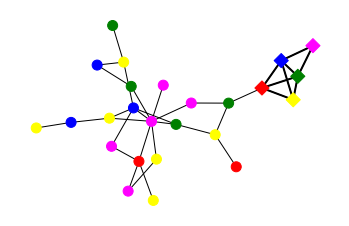

In [18]:
motif.draw_idx(8)

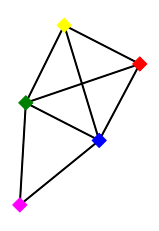

In [8]:
motif.draw_motif()

In [25]:
model = GCNClassifier(hidden_channels=64,
                      input_features=len(motif.NODE_CLS),
                      num_classes=len(motif.GRAPH_CLS),
                      num_layers=2)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [26]:
def train():
    model.train()
    losses = []
    for batch in tqdm(train_loader, position=1, leave=False, disable=True):
        model.zero_grad()  # Clear gradients.
        out = model(batch)  # Perform a single forward pass.
        loss = criterion(out, batch.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        losses.append(loss.item())
    return np.mean(losses)

@torch.no_grad()
def test(loader):
    model.eval()
    correct = 0
    for batch in tqdm(loader, position=1, leave=False, disable=True):
        out = model(batch)
        pred = out.argmax(dim=1) # Use the class with highest probability.
        correct += int((pred == batch.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.

@torch.no_grad()
def gt_score():
    batch = pyg.data.Batch.from_data_list([motif.motif])
    neg, pos = model(batch).mean(dim=0).numpy()
    return neg, pos

for epoch in trange(4, position=0, leave=True, disable=True):
    train_loss = train()
    train_acc = test(train_loader)
    test_acc = test(val_loader)
    neg, pos = gt_score()
    print(f'Epoch: {epoch:03d}, '
          f'Train Loss: {train_loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, '
          f'Test Acc: {test_acc:.4f}, '
          f'GT Pos Score: {pos:.4f}, '
          f'GT Neg Score: {neg:.4f}, ')

Epoch: 000, Train Loss: 0.6935, Train Acc: 0.5375, Test Acc: 0.5768, GT Pos Score: 0.0213, GT Neg Score: -0.0158, 
Epoch: 001, Train Loss: 0.6923, Train Acc: 0.5129, Test Acc: 0.5256, GT Pos Score: 0.1008, GT Neg Score: -0.1035, 
Epoch: 002, Train Loss: 0.5169, Train Acc: 0.9622, Test Acc: 0.9766, GT Pos Score: 23.5229, GT Neg Score: -24.1998, 
Epoch: 003, Train Loss: 0.0940, Train Acc: 0.9891, Test Acc: 0.9775, GT Pos Score: 63.3280, GT Neg Score: -64.6039, 


In [59]:
sampler = s = ConcreteGraphSampler(max_nodes=25,
                                   num_node_cls=len(motif.NODE_CLS),
                                   temperature=0.1,
                                   learn_node_feat=True)
criterion = nn.Sequential(
    ClassScoreCriterion(class_idx=1), # Maximize positive score
    NormPenalty(lambda: s.omega, order=1, weight=5), # L1 penalty on omega, encourage uncertainty
    NormPenalty(lambda: s.omega, order=2, weight=5), # L2 penalty on omega, avoid extreme probabilities
    NormPenalty(lambda: s.xi, order=1, weight=2), # L1 penalty on xi
    NormPenalty(lambda: s.xi, order=2, weight=2), # L2 penalty on xi
    BudgetPenalty(lambda: s.E, budget=10, beta=0.5, weight=np.linspace(0, 1100, num=2500)), # Budget penalty on theta, encourage sparsity
    CrossEntropyPenalty(lambda: s.theta, weight=0), # Element-wise entropy penalty on theta, encourage discreteness
    KLDivergencePenalty(lambda: tuple(s.E[s.pair_index]), binary=True, weight=10), # Pair-wise cross entropy on E, encourage connectivity
)
optimizer = torch.optim.Adam(s.parameters(), lr=0.1)

# construct graph sampler trainer
trainer = Trainer(sampler=sampler,
                  discriminator=model,
                  criterion=criterion,
                  optimizer=optimizer,
                  dataset=motif)

In [60]:
trainer.train(5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

n=5 m=10 neg=-20.120073 pos=19.637049


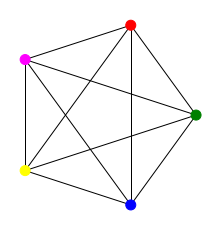

In [61]:
trainer.evaluate()

In [88]:
list(map(lambda x: format(x, ".2%"), sampler.theta.tolist()))

['0.01%',
 '0.02%',
 '0.00%',
 '0.00%',
 '0.01%',
 '0.00%',
 '0.01%',
 '0.01%',
 '0.00%',
 '0.01%',
 '0.01%',
 '0.01%',
 '0.02%',
 '0.01%',
 '0.02%',
 '0.01%',
 '0.01%',
 '0.01%',
 '0.01%',
 '0.02%',
 '0.02%',
 '0.02%',
 '0.01%',
 '0.02%',
 '0.02%',
 '0.01%',
 '0.01%',
 '0.02%',
 '0.00%',
 '0.01%',
 '0.01%',
 '0.02%',
 '0.02%',
 '0.03%',
 '0.02%',
 '0.02%',
 '0.02%',
 '0.02%',
 '0.02%',
 '0.01%',
 '0.02%',
 '0.02%',
 '0.01%',
 '0.01%',
 '0.03%',
 '0.02%',
 '0.02%',
 '0.00%',
 '0.02%',
 '0.03%',
 '0.02%',
 '0.03%',
 '0.00%',
 '0.01%',
 '0.02%',
 '0.02%',
 '0.01%',
 '0.02%',
 '0.01%',
 '0.01%',
 '99.99%',
 '0.03%',
 '99.70%',
 '0.02%',
 '0.02%',
 '99.93%',
 '0.02%',
 '0.04%',
 '0.02%',
 '0.04%',
 '0.01%',
 '0.03%',
 '0.00%',
 '0.01%',
 '0.02%',
 '99.90%',
 '99.98%',
 '0.00%',
 '0.01%',
 '0.00%',
 '0.00%',
 '0.01%',
 '99.98%',
 '0.00%',
 '0.00%',
 '0.01%',
 '0.02%',
 '0.02%',
 '0.02%',
 '0.01%',
 '0.03%',
 '0.02%',
 '0.03%',
 '0.02%',
 '0.00%',
 '0.02%',
 '0.03%',
 '0.00%',
 '0.02%',
 '0.

In [170]:
list(map(lambda x: format(x, ".2%"), sampler.E.tolist()))

['0.00%',
 '0.00%',
 '96.60%',
 '0.00%',
 '0.00%',
 '0.00%',
 '0.01%',
 '0.00%',
 '0.00%',
 '0.00%',
 '0.00%',
 '0.50%',
 '0.00%',
 '85.01%',
 '0.00%',
 '100.00%',
 '100.00%',
 '0.01%',
 '0.00%',
 '0.00%',
 '0.00%',
 '99.65%',
 '99.47%',
 '0.00%',
 '0.00%',
 '100.00%',
 '2.06%',
 '0.00%',
 '0.00%',
 '96.19%',
 '0.00%',
 '0.00%',
 '0.00%',
 '0.01%',
 '51.92%',
 '100.00%',
 '0.00%',
 '5.02%',
 '0.00%',
 '0.00%',
 '0.00%',
 '0.00%',
 '0.00%',
 '0.00%',
 '0.00%',
 '0.00%',
 '0.00%',
 '0.17%',
 '1.61%',
 '0.00%',
 '0.00%',
 '0.00%',
 '0.00%',
 '0.03%',
 '0.02%',
 '0.00%',
 '0.01%',
 '0.00%',
 '0.00%',
 '0.00%',
 '100.00%',
 '0.00%',
 '0.00%',
 '97.49%',
 '100.00%',
 '100.00%',
 '99.57%',
 '0.00%',
 '0.00%',
 '0.00%',
 '1.96%',
 '0.00%',
 '100.00%',
 '0.00%',
 '0.05%',
 '100.00%',
 '0.00%',
 '0.00%',
 '0.00%',
 '0.00%',
 '0.00%',
 '0.00%',
 '0.00%',
 '1.57%',
 '98.86%',
 '4.91%',
 '0.00%',
 '0.00%',
 '0.00%',
 '0.00%',
 '0.00%',
 '0.04%',
 '0.00%',
 '0.38%',
 '100.00%',
 '0.00%',
 '0.01%',
 

# Mutag

In [62]:
mutag = MUTAGDataset()
k_fold = 10
train_data = mutag[len(mutag)//k_fold:]
val_data = mutag[:len(mutag)//k_fold]
train_loader = pyg.loader.DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = pyg.loader.DataLoader(val_data, batch_size=128, shuffle=False)

In [66]:
model = GCNClassifier(hidden_channels=64,
                      input_features=len(mutag.NODE_CLS),
                      num_classes=len(mutag.GRAPH_CLS),
                      num_layers=6)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

In [67]:
def train():
    model.train()
    losses = []
    for batch in tqdm(train_loader, position=1, leave=False, disable=True):
        model.zero_grad()  # Clear gradients.
        out = model(batch)  # Perform a single forward pass.
        loss = criterion(out, batch.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        losses.append(loss.item())
    return np.mean(losses)

@torch.no_grad()
def test(loader):
    model.eval()
    correct = 0
    for batch in tqdm(loader, position=1, leave=False, disable=True):
        out = model(batch)
        pred = out.argmax(dim=1) # Use the class with highest probability.
        correct += int((pred == batch.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.

# @torch.no_grad()
# def gt_score():
#     batch = pyg.data.Batch.from_data_list([motif.motif])
#     neg, pos = model(batch).mean(dim=0).numpy()
#     return neg, pos

for epoch in trange(100, position=0, leave=True, disable=True):
    train_loss = train()
    train_acc = test(train_loader)
    test_acc = test(val_loader)
    # neg, pos = gt_score()
    print(f'Epoch: {epoch:03d}, '
          f'Train Loss: {train_loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, '
          f'Test Acc: {test_acc:.4f}, '
          # f'GT Pos Score: {pos:.4f}, '
          # f'GT Neg Score: {neg:.4f}, '
         )

Epoch: 000, Train Loss: 0.6984, Train Acc: 0.6706, Test Acc: 0.6111, 
Epoch: 001, Train Loss: 0.6690, Train Acc: 0.6706, Test Acc: 0.6111, 
Epoch: 002, Train Loss: 0.6138, Train Acc: 0.6706, Test Acc: 0.6111, 
Epoch: 003, Train Loss: 0.6486, Train Acc: 0.6706, Test Acc: 0.6111, 
Epoch: 004, Train Loss: 0.6080, Train Acc: 0.6706, Test Acc: 0.6111, 
Epoch: 005, Train Loss: 0.6378, Train Acc: 0.6706, Test Acc: 0.6111, 
Epoch: 006, Train Loss: 0.6233, Train Acc: 0.6706, Test Acc: 0.6111, 
Epoch: 007, Train Loss: 0.6405, Train Acc: 0.6706, Test Acc: 0.6111, 
Epoch: 008, Train Loss: 0.6401, Train Acc: 0.6706, Test Acc: 0.6111, 
Epoch: 009, Train Loss: 0.6196, Train Acc: 0.6706, Test Acc: 0.6111, 
Epoch: 010, Train Loss: 0.6194, Train Acc: 0.6706, Test Acc: 0.6111, 
Epoch: 011, Train Loss: 0.5960, Train Acc: 0.6706, Test Acc: 0.6111, 
Epoch: 012, Train Loss: 0.5675, Train Acc: 0.6706, Test Acc: 0.6111, 
Epoch: 013, Train Loss: 0.5757, Train Acc: 0.6706, Test Acc: 0.6111, 
Epoch: 014, Train Lo

In [116]:
sampler = s = ConcreteGraphSampler(max_nodes=25,
                                   num_node_cls=len(mutag.NODE_CLS),
                                   temperature=0.2,
                                   learn_node_feat=True)
criterion = nn.Sequential(
    ClassScoreCriterion(class_idx=1), # Maximize positive score
    NormPenalty(lambda: s.omega, order=1, weight=10), # L1 penalty on omega, encourage uncertainty
    NormPenalty(lambda: s.omega, order=2, weight=10), # L2 penalty on omega, avoid extreme probabilities
    NormPenalty(lambda: s.xi, order=1, weight=0), # L1 penalty on xi
    NormPenalty(lambda: s.xi, order=2, weight=0), # L2 penalty on xi
    BudgetPenalty(lambda: s.E, budget=5, beta=0.5, weight=np.linspace(0, 100, num=1500)), # Budget penalty on theta, encourage sparsity
    CrossEntropyPenalty(lambda: s.theta, weight=0), # Element-wise entropy penalty on theta, encourage discreteness
    KLDivergencePenalty(lambda: tuple(s.E[s.pair_index]), binary=True, weight=10), # Pair-wise cross entropy on E, encourage connectivity
)
optimizer = torch.optim.Adam(s.parameters(), lr=0.1)

# construct graph sampler trainer
trainer = Trainer(sampler=sampler,
                  discriminator=model,
                  criterion=criterion,
                  optimizer=optimizer,
                  dataset=mutag)

In [117]:
trainer.train(3000)

  0%|          | 0/3000 [00:00<?, ?it/s]

n=12 m=10 neg=-16.34086 pos=13.949151


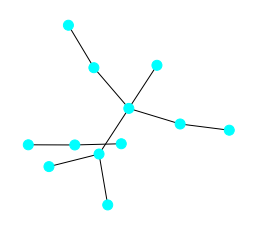

In [121]:
trainer.evaluate(threshold=0.1)

In [58]:
sampler = s = BinaryConcreteGraphSampler(n=40, k=7, temperature=0.25, learn_node_feat=True)
criterion = nn.Sequential(
    ClassScoreCriterion(class_idx=0), # Maximize score
    NormPenalty(lambda: s.omega, order=1, weight=2), # L1 penalty on omega, encourage uncertainty
    NormPenalty(lambda: s.omega, order=2, weight=30), # L2 penalty on omega, avoid extreme probabilities
    # TODO: change to E
    BudgetPenalty(lambda: s.theta, budget=20, beta=0.5, weight=1500), # Budget penalty on theta, encourage sparsity
    CrossEntropyPenalty(lambda: s.theta, weight=0), # Element-wise entropy penalty on theta, encourage discreteness
    KLDivergencePenalty(lambda: tuple(s.E[s.pair_index]), weight=100), # Pair-wise cross entropy on E, encourage connectivity





)
optimizer = torch.optim.Adam(s.parameters(), lr=0.1)

# construct graph sampler trainer
trainer = Trainer(sampler=sampler,
                  discriminator=model,
                  criterion=criterion,
                  optimizer=optimizer)

In [59]:
trainer.train(1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

iteration=0, loss=672.34, size=368.6706237792969, scores={'lollipop': [-3.3889951705932617]}
iteration=1, loss=649.91, size=355.6442565917969, scores={'lollipop': [-3.338984727859497]}
iteration=2, loss=583.38, size=342.67919921875, scores={'lollipop': [38.06742477416992]}
iteration=3, loss=605.39, size=329.7986755371094, scores={'lollipop': [-4.817610740661621]}
iteration=4, loss=548.81, size=317.0298767089844, scores={'lollipop': [28.420488357543945]}
iteration=5, loss=546.22, size=304.39862060546875, scores={'lollipop': [7.3642988204956055]}
iteration=6, loss=504.86, size=291.9309997558594, scores={'lollipop': [24.907941818237305]}
iteration=7, loss=489.65, size=279.6461181640625, scores={'lollipop': [17.52884292602539]}
iteration=8, loss=457.64, size=267.56005859375, scores={'lollipop': [26.161863327026367]}
iteration=9, loss=399.92, size=255.6922607421875, scores={'lollipop': [63.2998046875]}
iteration=10, loss=408.32, size=244.0624237060547, scores={'lollipop': [33.27487182617187

n=6 m=3


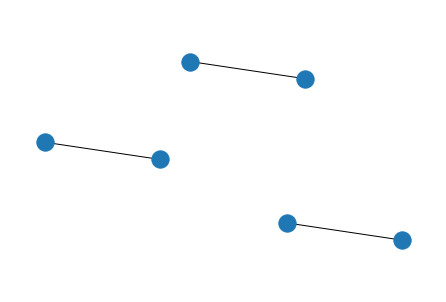

In [67]:
trainer.evaluate(0.035)

# Synthetic Data Generation

In [2]:
#generate random graph
def add_irregular_edges(G):
    new_edge_perc = np.random.uniform(high = 0.4)
    total_edges = G.number_of_edges()
    for i in range(np.int(np.round(new_edge_perc * total_edges))):
        #randomly select the starting node
        start = np.random.choice(np.array(G.nodes))
        prob = np.random.uniform()
        if (prob >= 0.5):
            #select ending nodes from exisiting node set
            end = np.random.choice(np.delete(G.nodes,start))
        else:
            #create new nodes
            end = G.number_of_nodes()
        G.add_edge(start,end)

16

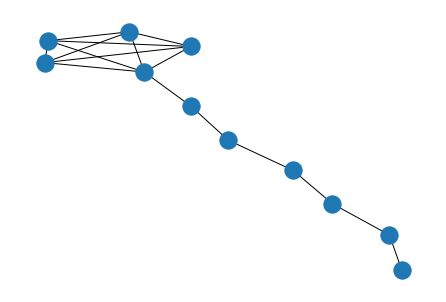

In [3]:
lolipop = nx.generators.lollipop_graph(5,6)
nx.draw(lolipop,pos=graphviz_layout(lolipop))
lolipop.number_of_nodes()
lolipop.number_of_edges()
#80

/var/folders/8r/3cqw5w7105xfsj57ks8fl5t40000gn/T/ipykernel_45692/1198588349.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  for i in range(np.int(np.round(new_edge_perc * total_edges))):


21

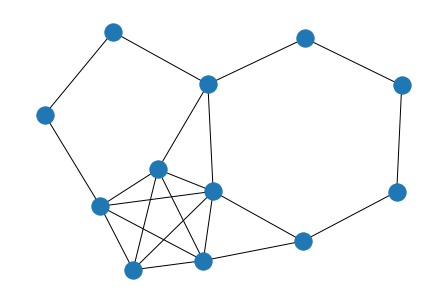

In [4]:
add_irregular_edges(lolipop)
nx.draw(lolipop,pos=graphviz_layout(lolipop))
lolipop.number_of_nodes()
lolipop.number_of_edges()

18

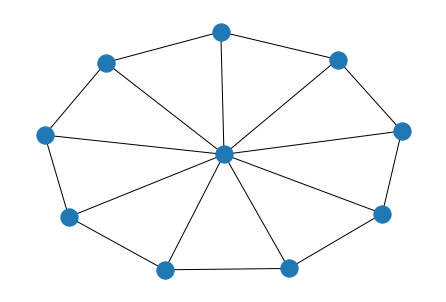

In [5]:
wheel = nx.generators.wheel_graph(10)
nx.draw(wheel,pos=graphviz_layout(wheel))
wheel.number_of_nodes()
wheel.number_of_edges()
#55

30

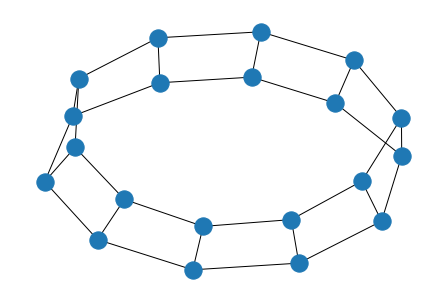

In [6]:
ladder = nx.generators.circular_ladder_graph(10)
nx.draw(ladder,pos=graphviz_layout(ladder))
ladder.number_of_nodes()
ladder.number_of_edges()
#52

20

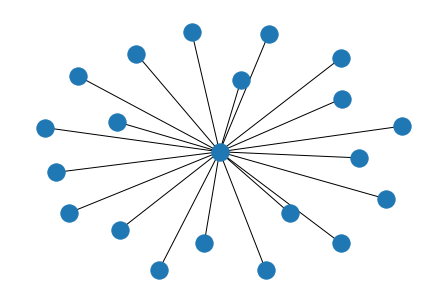

In [7]:
star = nx.generators.star_graph(20)
nx.draw(star,pos=graphviz_layout(star))
star.number_of_nodes()
star.number_of_edges()
#50

/var/folders/8r/3cqw5w7105xfsj57ks8fl5t40000gn/T/ipykernel_45692/1198588349.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  for i in range(np.int(np.round(new_edge_perc * total_edges))):


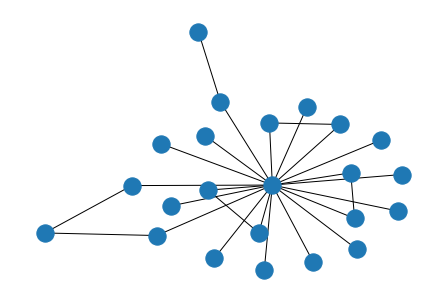

In [8]:
add_irregular_edges(star)
nx.draw(star,pos=graphviz_layout(star))


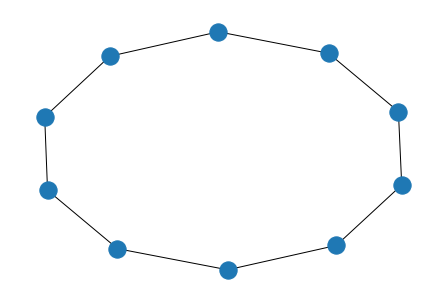

In [7]:
cycle = nx.generators.cycle_graph(10)
nx.draw(cycle, pos=graphviz_layout(cycle))

In [9]:
lolipop_G_list = []
length = 4000
lolipop_label = []
for i in tqdm(range(length)):
    m = np.random.randint(3,21)
    n = np.random.randint(1,21)
    lolipop = nx.generators.lollipop_graph(m,n)
    add_irregular_edges(lolipop)
    lolipop_G_list.append(lolipop)
    #lolipop graph is 0
    lolipop_label.append(0)

  0%|          | 0/4000 [00:00<?, ?it/s]

/var/folders/8r/3cqw5w7105xfsj57ks8fl5t40000gn/T/ipykernel_45692/1198588349.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  for i in range(np.int(np.round(new_edge_perc * total_edges))):


In [10]:
wheel_G_list = []
length = 4000
wheel_label = []
for i in tqdm(range(length)):
    n = np.random.randint(3,41)
    wheel = nx.generators.wheel_graph(n)
    add_irregular_edges(wheel)
    wheel_G_list.append(wheel)
    #wheel graph is 1
    wheel_label.append(1)

  0%|          | 0/4000 [00:00<?, ?it/s]

/var/folders/8r/3cqw5w7105xfsj57ks8fl5t40000gn/T/ipykernel_45692/1198588349.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  for i in range(np.int(np.round(new_edge_perc * total_edges))):


In [11]:
ladder_G_list = []
length = 4000
ladder_label = []
for i in tqdm(range(length)):
    n = np.random.randint(2,21)
    ladder = nx.generators.circular_ladder_graph(n)
    add_irregular_edges(ladder)
    ladder_G_list.append(ladder)
    #ladder graph is 2
    ladder_label.append(2)

  0%|          | 0/4000 [00:00<?, ?it/s]

/var/folders/8r/3cqw5w7105xfsj57ks8fl5t40000gn/T/ipykernel_45692/1198588349.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  for i in range(np.int(np.round(new_edge_perc * total_edges))):


In [12]:
star_G_list = []
length = 4000
star_label = []
for i in tqdm(range(length)):
    n = np.random.randint(3,40)
    star = nx.generators.star_graph(n)
    add_irregular_edges(star)
    star_G_list.append(star)
    #star graph is 3
    star_label.append(3)

  0%|          | 0/4000 [00:00<?, ?it/s]

/var/folders/8r/3cqw5w7105xfsj57ks8fl5t40000gn/T/ipykernel_45692/1198588349.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  for i in range(np.int(np.round(new_edge_perc * total_edges))):


In [13]:
G_list = lolipop_G_list + wheel_G_list + ladder_G_list + star_G_list
labels = lolipop_label + wheel_label + ladder_label + star_label
data_list = generate_data_list(G_list, edge_index='raw_edge_index', label=labels)

preprocess G:   0%|          | 0/16000 [00:00<?, ?it/s]

In [14]:
index = list(range(len(G_list)))
random.shuffle(index)

train_index = index[:15000]
val_index = index[15000:16000]
test_index = index[16000:]

In [15]:
#split data list
train_data_list = list(map(data_list.__getitem__, train_index))
val_data_list = list(map(data_list.__getitem__, val_index))
test_data_list = list(map(data_list.__getitem__, test_index))

#split G list
train_G_list = list(map(G_list.__getitem__, train_index))
val_G_list = list(map(G_list.__getitem__, val_index))
test_G_list = list(map(G_list.__getitem__, test_index))

In [16]:
pickle.dump(train_data_list, open('./GNN_XAI_data/randomE_train_data_list.pkl', 'wb'))
pickle.dump(val_data_list, open('./GNN_XAI_data/randomE_val_data_list.pkl', 'wb'))
pickle.dump(test_data_list, open('./GNN_XAI_data/randomE_test_data_list.pkl', 'wb'))
pickle.dump(train_G_list, open('./GNN_XAI_data/randomE_train_G_list.pkl', 'wb'))
pickle.dump(val_G_list, open('./GNN_XAI_data/randomE_val_G_list.pkl', 'wb'))
pickle.dump(test_G_list, open('./GNN_XAI_data/randomE_test_G_list.pkl', 'wb'))

# Train a Graph Classifier

In [17]:
train_data_list = pickle.load(open('./GNN_XAI_data/randomE_train_data_list.pkl', 'rb'))
val_data_list = pickle.load(open('./GNN_XAI_data/randomE_val_data_list.pkl', 'rb'))
test_data_list = pickle.load(open('./GNN_XAI_data/randomE_test_data_list.pkl', 'rb'))
train_G_list = pickle.load(open('./GNN_XAI_data/randomE_train_G_list.pkl', 'rb'))
val_G_list = pickle.load(open('./GNN_XAI_data/randomE_val_G_list.pkl', 'rb'))
test_G_list = pickle.load(open('./GNN_XAI_data/randomE_test_G_list.pkl', 'rb'))

In [18]:
batch_size = 64
train_loader = DataLoader(train_data_list, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data_list, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data_list, batch_size=batch_size, shuffle=False)

/usr/local/anaconda3/envs/deepgd/lib/python3.9/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [19]:
batch, *_ = iter(train_loader)

In [20]:
batch

Batch(x=[1709], n=[64], m=[64], raw_edge_index=[2, 6414], edge_pair_index=[4, 127388], raw_edge_attr=[6414, 2], full_edge_index=[2, 53554], full_edge_attr=[53554, 2], label=[64], pos=[1709, 2], edge_index=[2, 6414], edge_attr=[53554, 2], batch=[1709], ptr=[65])

In [21]:
class GraphClassifier(nn.Module):
    def __init__(self, hidden_channels, input_features = 1,num_classes = 4):
        super(GraphClassifier, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = pyg.nn.GCNConv(input_features, hidden_channels)
        self.conv2 = pyg.nn.GCNConv(hidden_channels, hidden_channels)
        self.conv3 = pyg.nn.GCNConv(hidden_channels, hidden_channels)
#         self.conv4 = GCNConv(hidden_channels, hidden_channels)

        self.lin1 = nn.Linear(hidden_channels, hidden_channels)
        self.out = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
#         x = x.relu()
#         x = self.conv4(x, edge_index)
        
        # 2. Readout layer
        x = pyg.nn.global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.lin1(x)
        x = x.relu()
        x = self.out(x)
        
        return x

In [22]:
model = GraphClassifier(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    for batch in train_loader:  # Iterate in batches over the training dataset.
        out = model(torch.ones_like(batch.x)[:,None], batch.edge_index, batch.batch)  # Perform a single forward pass.
        loss = criterion(out, batch.label.long())  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()

    correct = 0
    for batch in loader:  # Iterate in batches over the training/test dataset.
        out = model(torch.ones_like(batch.x)[:,None], batch.edge_index,batch.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == batch.label).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in tqdm(range(1, 201)):
    train()
    train_acc = test(train_loader)
    test_acc = test(val_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 001, Train Acc: 0.7331, Test Acc: 0.7400
Epoch: 002, Train Acc: 0.6987, Test Acc: 0.6850
Epoch: 003, Train Acc: 0.7781, Test Acc: 0.7680
Epoch: 004, Train Acc: 0.7567, Test Acc: 0.7460
Epoch: 005, Train Acc: 0.7464, Test Acc: 0.7610
Epoch: 006, Train Acc: 0.7556, Test Acc: 0.7480
Epoch: 007, Train Acc: 0.7638, Test Acc: 0.7760
Epoch: 008, Train Acc: 0.7679, Test Acc: 0.7420
Epoch: 009, Train Acc: 0.7386, Test Acc: 0.7180
Epoch: 010, Train Acc: 0.7875, Test Acc: 0.7820
Epoch: 011, Train Acc: 0.6451, Test Acc: 0.6670
Epoch: 012, Train Acc: 0.7661, Test Acc: 0.7890
Epoch: 013, Train Acc: 0.7954, Test Acc: 0.7870
Epoch: 014, Train Acc: 0.7963, Test Acc: 0.7820
Epoch: 015, Train Acc: 0.7931, Test Acc: 0.7740
Epoch: 016, Train Acc: 0.8021, Test Acc: 0.8090
Epoch: 017, Train Acc: 0.8028, Test Acc: 0.7870
Epoch: 018, Train Acc: 0.8223, Test Acc: 0.8270
Epoch: 019, Train Acc: 0.8001, Test Acc: 0.8000
Epoch: 020, Train Acc: 0.7849, Test Acc: 0.7780
Epoch: 021, Train Acc: 0.8003, Test Acc:

In [28]:
torch.save(model.state_dict(), "model_randomE.ckpt")

In [29]:
#star validation loader
star_index = (Batch.from_data_list(val_data_list).label.long() == 3).numpy()
val_data_array = np.zeros(len(val_data_list), dtype=object)
for i in range(len(val_data_list)):
    val_data_array[i] = val_data_list[i]
star_val_loader = DataLoader(val_data_array[star_index].tolist(), batch_size=batch_size, shuffle=False)

#ladder validation loader
ladder_index = (Batch.from_data_list(val_data_list).label.long() == 2).numpy()
val_data_array = np.zeros(len(val_data_list), dtype=object)
for i in range(len(val_data_list)):
    val_data_array[i] = val_data_list[i]
ladder_val_loader = DataLoader(val_data_array[ladder_index].tolist(), batch_size=batch_size, shuffle=False)

#wheel validation loader
wheel_index = (Batch.from_data_list(val_data_list).label.long() == 1).numpy()
val_data_array = np.zeros(len(val_data_list), dtype=object)
for i in range(len(val_data_list)):
    val_data_array[i] = val_data_list[i]
wheel_val_loader = DataLoader(val_data_array[wheel_index].tolist(), batch_size=batch_size, shuffle=False)


#lolipop validation loader
lolipop_index = (Batch.from_data_list(val_data_list).label.long() == 0).numpy()
val_data_array = np.zeros(len(val_data_list), dtype=object)
for i in range(len(val_data_list)):
    val_data_array[i] = val_data_list[i]
lolipop_val_loader = DataLoader(val_data_array[lolipop_index].tolist(), batch_size=batch_size, shuffle=False)

In [30]:
#evaluate test accuracy for each class
model.eval()

correct = 0
for batch in star_val_loader:  # Iterate in batches over the training/test dataset.
     out = model(torch.ones_like(batch.x)[:,None], batch.edge_index,batch.batch)  
     pred = out.argmax(dim=1)  # Use the class with highest probability.
     correct += int((pred == batch.label).sum())  # Check against ground-truth labels.
star_accu = correct / len(star_val_loader.dataset)  # Derive ratio of correct predictions.

correct = 0
for batch in ladder_val_loader:  # Iterate in batches over the training/test dataset.
     out = model(torch.ones_like(batch.x)[:,None], batch.edge_index,batch.batch)  
     pred = out.argmax(dim=1)  # Use the class with highest probability.
     correct += int((pred == batch.label).sum())  # Check against ground-truth labels.
ladder_accu = correct / len(ladder_val_loader.dataset)  # Derive ratio of correct predictions.

correct = 0
for batch in wheel_val_loader:  # Iterate in batches over the training/test dataset.
     out = model(torch.ones_like(batch.x)[:,None], batch.edge_index,batch.batch)  
     pred = out.argmax(dim=1)  # Use the class with highest probability.
     correct += int((pred == batch.label).sum())  # Check against ground-truth labels.
wheel_accu = correct / len(wheel_val_loader.dataset)  # Derive ratio of correct predictions.

correct = 0
for batch in lolipop_val_loader:  # Iterate in batches over the training/test dataset.
     out = model(torch.ones_like(batch.x)[:,None], batch.edge_index,batch.batch)  
     pred = out.argmax(dim=1)  # Use the class with highest probability.
     correct += int((pred == batch.label).sum())  # Check against ground-truth labels.
lolipop_accu = correct / len(lolipop_val_loader.dataset)  # Derive ratio of correct predictions.

print("star",star_accu)
print("ladder", ladder_accu)
print("wheel", wheel_accu)
print("lolipop",lolipop_accu)

star 1.0
ladder 0.8467741935483871
wheel 0.9244444444444444
lolipop 0.9552238805970149


# Reparametrizied GCNConv

In [2]:
class GCNGraphDiscriminator(nn.Module):
    def __init__(self, hidden_channels, input_features=1, num_classes=4):
        super().__init__()
        self.conv1 = pyg.nn.GCNConv(input_features, hidden_channels)
        self.conv2 = pyg.nn.GCNConv(hidden_channels, hidden_channels)
        self.conv3 = pyg.nn.GCNConv(hidden_channels, hidden_channels)
        self.lin1 = nn.Linear(hidden_channels, hidden_channels)
        self.out = nn.Linear(hidden_channels, num_classes)

    def forward(self, batch):
        # For graph optimization, process a single graph at a time
        assert batch.num_graphs == 1

        # 1. Obtain node embeddings
        x = batch.x
        x = self.conv1(x, batch.edge_index, batch.E).relu()
        x = self.conv2(x, batch.edge_index, batch.E).relu()
        x = self.conv3(x, batch.edge_index, batch.E)
        
        # 2. Readout layer
        x = pyg.nn.global_mean_pool(x, batch.batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = self.lin1(x).relu()
        x = self.out(x)

        # Take the first element, as the batch size is 1
        return x[0]

# Load Discriminator

In [23]:
#load model
discriminator = GCNGraphDiscriminator(hidden_channels=64)
discriminator.load_state_dict(torch.load("model_randomE.ckpt"))

<All keys matched successfully>

In [24]:
idx = {'lollipop': 0, 'wheel': 1, 'ladder': 2, 'star': 3}
sampler = {}
criterion = {}
optimizer = {}
trainer = {}
result = {}
neg_sampler = {}
neg_criterion = {}
neg_optimizer = {}
neg_trainer = {}
neg_result = {}

# Star Graph Interpretation

In [25]:
cls = 'star'
sampler[cls] = s = BinaryConcreteGraphSampler(nodes=40, temperature=0.25)
criterion[cls] = nn.Sequential(
    ClassScoreCriterion(class_idx=idx[cls]), # Maximize score
    NormPenalty(lambda: s.omega, order=1, weight=2), # L1 penalty on omega, encourage uncertainty
    NormPenalty(lambda: s.omega, order=2, weight=30), # L2 penalty on omega, avoid extreme probabilities
    # TODO: change to E
    BudgetPenalty(lambda: s.theta, budget=20, beta=0.5, weight=1500), # Budget penalty on theta, encourage sparsity
    CrossEntropyPenalty(lambda: s.theta, weight=0), # Element-wise entropy penalty on theta, encourage discreteness
    KLDivergencePenalty(lambda: tuple(s.E[s.pair_index]), weight=100), # Pair-wise cross entropy on E, encourage connectivity
)
optimizer[cls] = torch.optim.Adam(s.parameters(), lr=0.1)

# construct graph sampler trainer
trainer[cls] = Trainer(sampler=sampler[cls],
                       discriminator=discriminator,
                       criterion=criterion[cls],
                       optimizer=optimizer[cls])

## Traing Positive Sampler

In [14]:
trainer['star'].train(iterations=3000)

  0%|          | 0/3000 [00:00<?, ?it/s]

/usr/local/anaconda3/envs/deepgd/lib/python3.9/site-packages/torch/nn/functional.py:2741: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


iteration=0, loss=685.58, size=374.4007873535156, scores={'lollipop': 2.301945686340332, 'wheel': -1.1991326808929443, 'ladder': 0.337998628616333, 'star': -4.02880859375}
iteration=1, loss=662.99, size=361.5489196777344, scores={'lollipop': 1.9016244411468506, 'wheel': -0.23964977264404297, 'ladder': 0.8092762231826782, 'star': -6.6070451736450195}
iteration=2, loss=639.17, size=348.7572021484375, scores={'lollipop': 2.0665628910064697, 'wheel': -0.3061990737915039, 'ladder': 0.5997689962387085, 'star': -6.040376663208008}
iteration=3, loss=614.64, size=336.03009033203125, scores={'lollipop': 2.0626206398010254, 'wheel': -0.5787274837493896, 'ladder': 0.6175609827041626, 'star': -5.640703201293945}
iteration=4, loss=595.34, size=323.4131164550781, scores={'lollipop': 2.3374500274658203, 'wheel': 0.5929865837097168, 'ladder': 0.2086491584777832, 'star': -6.6299333572387695}
iteration=5, loss=569.64, size=310.9042053222656, scores={'lollipop': 2.1890625953674316, 'wheel': -0.49850320816

In [26]:
cls = 'star'
sampler[cls].load(f'sampler_{cls}.ckpt')

## Draw Positive Sample

n=34 m=34


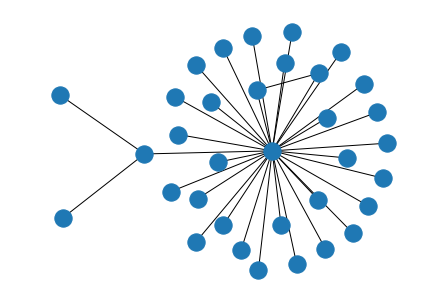

In [27]:
cls = 'star'
result[cls] = trainer[cls].evaluate(0.1)

## Inspect Theta and E

In [ ]:
# The values of latent theta are soft
list(map(lambda x: format(x, ".2%"), sampler['star'].theta.tolist()))

In [ ]:
# The values of sampled E are almost discrete
list(map(lambda x: format(x, ".2%"), sampler['star'].E.tolist()))

In [ ]:
cls = 'star'
sampler[cls].save(f'sampler_{cls}.ckpt')

## Create Negative Sampler

In [24]:
cls = 'star'
neg_sampler[cls] = s = BinaryConcreteGraphSampler(n=40, edges=result[cls].edges)
neg_criterion[cls] = nn.Sequential(
    ClassScoreCriterion(class_idx=idx[cls], mode='minimize'), # Minimize score
    NormPenalty(lambda: s.omega, order=1, weight=0), # L1 penalty on omega, encourage uncertainty
    NormPenalty(lambda: s.omega, order=2, weight=10), # L2 penalty on omega, avoid extreme probabilities
    # TODO: change to E
    BudgetPenalty(lambda: s.theta, budget=5, beta=0.5, weight=0), # Budget penalty on theta, encourage sparsity
    CrossEntropyPenalty(lambda: s.theta, weight=0), # Element-wise entropy penalty on theta, encourage discreteness
    KLDivergencePenalty(lambda: tuple(s.E[s.pair_index]), weight=0), # Pair-wise cross entropy on E, encourage connectivity
)
neg_optimizer[cls] = torch.optim.Adam(s.parameters(), lr=0.1)

# construct graph sampler trainer
neg_trainer[cls] = Trainer(sampler=neg_sampler[cls],
                           discriminator=discriminator,
                           criterion=neg_criterion[cls],
                           optimizer=neg_optimizer[cls])

## Train Negative Sampler

In [25]:
neg_trainer['star'].train(iterations=3000)

  0%|          | 0/3000 [00:00<?, ?it/s]

/usr/local/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:2741: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


iteration=0, loss=18.82, size=16.669641494750977, scores={'lollipop': -23.395849227905273, 'wheel': -6.217453956604004, 'ladder': -29.006298065185547, 'star': 15.492179870605469}
iteration=1, loss=3.17, size=16.325593948364258, scores={'lollipop': -12.95763111114502, 'wheel': -1.4254875183105469, 'ladder': -21.448936462402344, 'star': -0.1465282440185547}
iteration=2, loss=19.99, size=15.974486351013184, scores={'lollipop': -18.964214324951172, 'wheel': -7.500359058380127, 'ladder': -24.52153205871582, 'star': 16.67194175720215}
iteration=3, loss=4.12, size=15.72689151763916, scores={'lollipop': -10.693523406982422, 'wheel': -2.0884957313537598, 'ladder': -19.352436065673828, 'star': 0.8182787895202637}
iteration=4, loss=14.82, size=15.452391624450684, scores={'lollipop': -17.731151580810547, 'wheel': -5.288845062255859, 'ladder': -25.231571197509766, 'star': 11.537363052368164}
iteration=5, loss=7.09, size=15.171777725219727, scores={'lollipop': -8.498607635498047, 'wheel': -3.7398293

## Draw Negative Sample

n=8 m=7


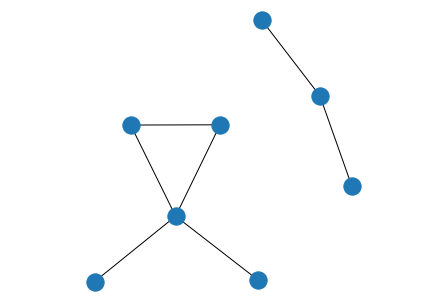

In [26]:
cls = 'star'
neg_trainer[cls].evaluate(0.4)

## Draw Contrastive Sample

n=34 m=27


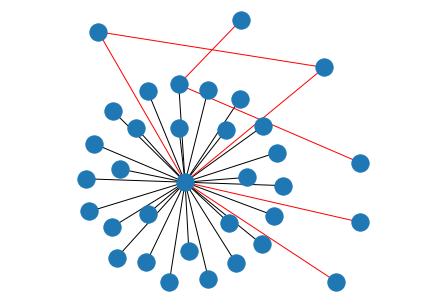

In [27]:
cls = 'star'
neg_result[cls] = neg_trainer[cls].evaluate_neg(0.4)

n=34 m=27


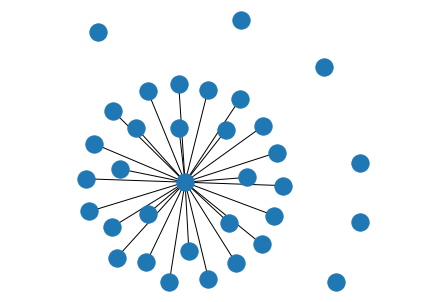

In [28]:
cls = 'star'
neg_result[cls] = neg_trainer[cls].evaluate_neg(0.4, show_neg_edges=False)

# Lollipop Graph Interpretation

In [29]:
cls = 'lollipop'
sampler[cls] = s = BinaryConcreteGraphSampler(n=30, temperature=0.25)
criterion[cls] = nn.Sequential(
    ClassScoreCriterion(class_idx=idx[cls]), # Maximize score
    NormPenalty(lambda: s.omega, order=1, weight=5), # L1 penalty on omega, encourage uncertainty
    NormPenalty(lambda: s.omega, order=2, weight=25), # L2 penalty on omega, avoid extreme probabilities
    BudgetPenalty(lambda: s.E, budget=120, beta=0.5, weight=2000), # Budget penalty on theta, encourage sparsity
    CrossEntropyPenalty(lambda: s.theta, weight=0), # Element-wise entropy penalty on theta, encourage discreteness
    KLDivergencePenalty(lambda: tuple(s.E[s.pair_index]), weight=50), # Pair-wise cross entropy on E, encourage connectivity
)
optimizer[cls] = torch.optim.Adam(s.parameters(), lr=0.5)

# construct graph sampler trainer
trainer[cls] = Trainer(sampler=sampler[cls],
                       discriminator=discriminator,
                       criterion=criterion[cls],
                       optimizer=optimizer[cls])

## Traing Positive Sampler

In [650]:
trainer['lollipop'].train(iterations=3000)

  0%|          | 0/3000 [00:00<?, ?it/s]

iteration=0, loss=438.31, size=180.17999267578125, scores={'lollipop': 2.0947265625, 'wheel': -0.8297263383865356, 'ladder': 0.5878820419311523, 'star': -5.171561241149902}
iteration=1, loss=271.62, size=145.0871124267578, scores={'lollipop': 2.1007423400878906, 'wheel': -1.2391566038131714, 'ladder': 0.599223256111145, 'star': -4.5373616218566895}
iteration=2, loss=115.83, size=113.58761596679688, scores={'lollipop': 0.19948899745941162, 'wheel': 2.1605920791625977, 'ladder': -2.13230562210083, 'star': -7.895868301391602}
iteration=3, loss=5.87, size=90.67453002929688, scores={'lollipop': 0.2651999592781067, 'wheel': 1.3038032054901123, 'ladder': 0.04272258281707764, 'star': -5.39321231842041}
iteration=4, loss=7.56, size=73.98970794677734, scores={'lollipop': 1.453643560409546, 'wheel': -1.343703269958496, 'ladder': -1.3733024597167969, 'star': -3.1213226318359375}
iteration=5, loss=11.56, size=61.99828338623047, scores={'lollipop': -0.015109062194824219, 'wheel': -0.4936814308166504

In [30]:
cls = 'lollipop'
sampler[cls].load(f'sampler_{cls}.ckpt')

## Draw Positive Sample

n=30 m=119


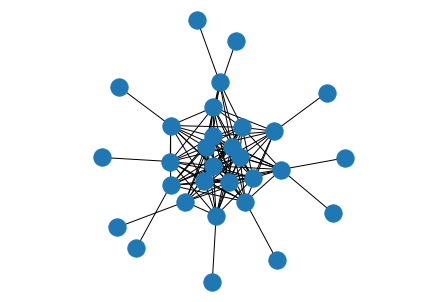

In [36]:
cls = 'lollipop'
result[cls] = trainer[cls].evaluate(0.5)

In [ ]:
cls = 'lollipop'
sampler[cls].save(f'sampler_{cls}.ckpt')

## Create Negative Sampler

In [37]:
cls = 'lollipop'
neg_sampler[cls] = s = BinaryConcreteGraphSampler(n=30, edges=result[cls].edges)
neg_criterion[cls] = nn.Sequential(
    ClassScoreCriterion(class_idx=idx[cls], mode='minimize'), # Minimize score
    NormPenalty(lambda: s.omega, order=1, weight=0), # L1 penalty on omega, encourage uncertainty
    NormPenalty(lambda: s.omega, order=2, weight=5), # L2 penalty on omega, avoid extreme probabilities
    # TODO: change to E
    BudgetPenalty(lambda: s.theta, budget=10, beta=0.5, weight=100), # Budget penalty on theta, encourage sparsity
    CrossEntropyPenalty(lambda: s.theta, weight=0), # Element-wise entropy penalty on theta, encourage discreteness
    KLDivergencePenalty(lambda: tuple(s.E[s.pair_index]), weight=0), # Pair-wise cross entropy on E, encourage connectivity
)
neg_optimizer[cls] = torch.optim.Adam(s.parameters(), lr=0.1)

# construct graph sampler trainer
neg_trainer[cls] = Trainer(sampler=neg_sampler[cls],
                           discriminator=discriminator,
                           criterion=neg_criterion[cls],
                           optimizer=neg_optimizer[cls])

## Train Negative Sampler

In [38]:
neg_trainer['lollipop'].train(iterations=3000)

  0%|          | 0/3000 [00:00<?, ?it/s]

iteration=0, loss=112.15, size=63.561405181884766, scores={'lollipop': 64.81755065917969, 'wheel': -18.59503173828125, 'ladder': -25.430564880371094, 'star': -135.01502990722656}
iteration=1, loss=93.55, size=61.85369873046875, scores={'lollipop': 47.68366622924805, 'wheel': -14.834266662597656, 'ladder': -25.542850494384766, 'star': -101.55198669433594}
iteration=2, loss=94.64, size=60.22407531738281, scores={'lollipop': 50.21666717529297, 'wheel': -14.3725004196167, 'ladder': -23.297996520996094, 'star': -106.85620880126953}
iteration=3, loss=98.74, size=58.61921691894531, scores={'lollipop': 55.679935455322266, 'wheel': -16.23099708557129, 'ladder': -24.225242614746094, 'star': -119.38117980957031}
iteration=4, loss=85.74, size=57.03358459472656, scores={'lollipop': 44.02973175048828, 'wheel': -12.384601593017578, 'ladder': -21.69049072265625, 'star': -92.59168243408203}
iteration=5, loss=98.59, size=55.45604705810547, scores={'lollipop': 58.2106819152832, 'wheel': -16.4043502807617

## Draw Negative Sample

n=19 m=25


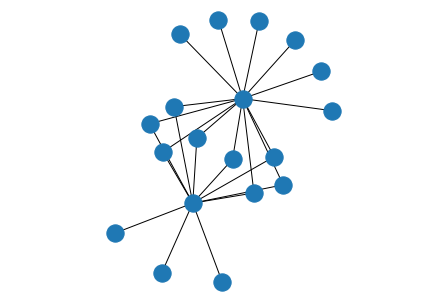

In [59]:
cls = 'lollipop'
neg_trainer[cls].evaluate(0.2)

## Draw Contrastive Sample

n=30 m=94


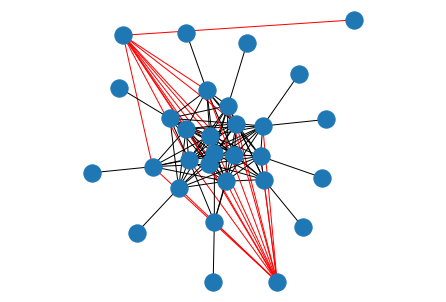

In [60]:
cls = 'lollipop'
neg_result[cls] = neg_trainer[cls].evaluate_neg(0.2)

n=30 m=94


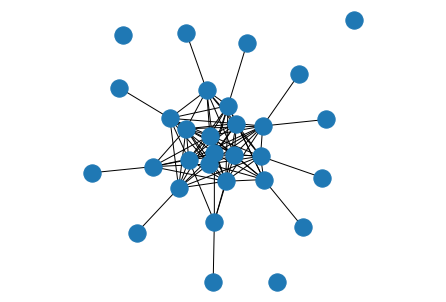

In [61]:
cls = 'lollipop'
neg_result[cls] = neg_trainer[cls].evaluate_neg(0.2, show_neg_edges=False)

# Wheel Graph Interpretation

In [43]:
cls = 'wheel'
sampler[cls] = s = BinaryConcreteGraphSampler(n=30, temperature=0.4)
criterion[cls] = nn.Sequential(
    ClassScoreCriterion(class_idx=idx[cls]), # Maximize score
    NormPenalty(lambda: s.omega, order=1, weight=5), # L1 penalty on omega, encourage uncertainty
    NormPenalty(lambda: s.omega, order=2, weight=30), # L2 penalty on omega, avoid extreme probabilities
    BudgetPenalty(lambda: s.E, budget=40, beta=0.5, weight=120), # Budget penalty on theta, encourage sparsity
    CrossEntropyPenalty(lambda: s.theta, weight=0), # Element-wise entropy penalty on theta, encourage discreteness
    KLDivergencePenalty(lambda: tuple(s.E[s.pair_index]), weight=60), # Pair-wise cross entropy on E, encourage connectivity
)
optimizer[cls] = torch.optim.Adam(s.parameters(), lr=0.5)

# construct graph sampler trainer
trainer[cls] = Trainer(sampler=sampler[cls],
                       discriminator=discriminator,
                       criterion=criterion[cls],
                       optimizer=optimizer[cls])

## Train Positive Sampler

In [93]:
trainer['wheel'].train(iterations=3000)

  0%|          | 0/3000 [00:00<?, ?it/s]

iteration=0, loss=16.05, size=60.08338165283203, scores={'lollipop': -21.913766860961914, 'wheel': 13.921664237976074, 'ladder': -37.64670181274414, 'star': -23.403789520263672}
iteration=1, loss=14.84, size=65.0709457397461, scores={'lollipop': -21.31627655029297, 'wheel': 13.29262638092041, 'ladder': -36.27885437011719, 'star': -23.27238655090332}
iteration=2, loss=18.58, size=69.45637512207031, scores={'lollipop': -17.431983947753906, 'wheel': 10.701764106750488, 'ladder': -30.006309509277344, 'star': -18.75114631652832}
iteration=3, loss=13.66, size=72.56341552734375, scores={'lollipop': -21.701034545898438, 'wheel': 13.24804401397705, 'ladder': -29.3900203704834, 'star': -17.7990779876709}
iteration=4, loss=23.15, size=74.59331512451172, scores={'lollipop': -10.938273429870605, 'wheel': 6.144400596618652, 'ladder': -19.743999481201172, 'star': -12.095165252685547}
iteration=5, loss=19.99, size=75.75386047363281, scores={'lollipop': -14.691574096679688, 'wheel': 7.581940650939941, 

KeyboardInterrupt: 

In [54]:
cls = 'wheel'
sampler[cls].load(f'sampler_{cls}.ckpt')

## Draw Positive Sample

n=29 m=66


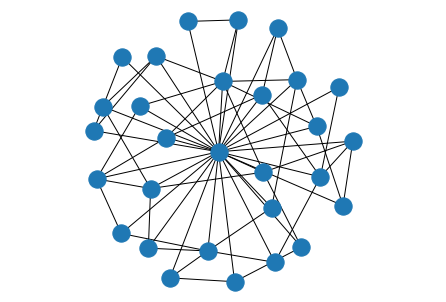

In [45]:
cls = 'wheel'
result[cls] = trainer[cls].evaluate(0.15)

In [761]:
cls = 'wheel'
sampler[cls].save(f'sampler_{cls}.ckpt')

## Create Negative Sampler

In [46]:
cls = 'wheel'
neg_sampler[cls] = s = BinaryConcreteGraphSampler(n=30, edges=result[cls].edges)
neg_criterion[cls] = nn.Sequential(
    ClassScoreCriterion(class_idx=idx[cls], mode='minimize'), # Minimize score
    NormPenalty(lambda: s.omega, order=1, weight=1), # L1 penalty on omega, encourage uncertainty
    NormPenalty(lambda: s.omega, order=2, weight=10), # L2 penalty on omega, avoid extreme probabilities
    # TODO: change to E
    BudgetPenalty(lambda: s.theta, budget=5, beta=0.5, weight=40), # Budget penalty on theta, encourage sparsity
    CrossEntropyPenalty(lambda: s.theta, weight=0), # Element-wise entropy penalty on theta, encourage discreteness
    KLDivergencePenalty(lambda: tuple(s.E[s.pair_index]), weight=0), # Pair-wise cross entropy on E, encourage connectivity
)
neg_optimizer[cls] = torch.optim.Adam(s.parameters(), lr=0.1)

# construct graph sampler trainer
neg_trainer[cls] = Trainer(sampler=neg_sampler[cls],
                           discriminator=discriminator,
                           criterion=neg_criterion[cls],
                           optimizer=neg_optimizer[cls])

## Train Negative Sampler

In [47]:
neg_trainer['wheel'].train(iterations=3000)

  0%|          | 0/3000 [00:00<?, ?it/s]

iteration=0, loss=22.42, size=33.725955963134766, scores={'lollipop': -10.087143898010254, 'wheel': 1.2770578861236572, 'ladder': -18.278589248657227, 'star': -4.619542121887207}
iteration=1, loss=27.08, size=32.914817810058594, scores={'lollipop': -14.839512825012207, 'wheel': 6.486762046813965, 'ladder': -23.93927574157715, 'star': -14.704900741577148}
iteration=2, loss=21.59, size=32.12540817260742, scores={'lollipop': -9.802040100097656, 'wheel': 1.5353174209594727, 'ladder': -18.65057945251465, 'star': -4.793148994445801}
iteration=3, loss=21.72, size=31.313383102416992, scores={'lollipop': -9.09343433380127, 'wheel': 2.167518138885498, 'ladder': -15.996170043945312, 'star': -6.975700378417969}
iteration=4, loss=21.71, size=30.513595581054688, scores={'lollipop': -8.951364517211914, 'wheel': 2.678335666656494, 'ladder': -17.014625549316406, 'star': -7.248230934143066}
iteration=5, loss=23.62, size=29.750343322753906, scores={'lollipop': -13.796655654907227, 'wheel': 5.090605258941

## Draw Negative Sample

n=9 m=8


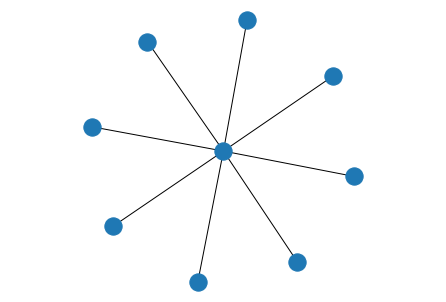

In [49]:
cls = 'wheel'
neg_trainer[cls].evaluate(0.3)

## Draw Contrasitve Sample

n=29 m=58


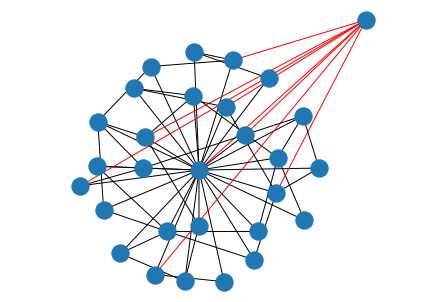

In [52]:
cls = 'wheel'
neg_result[cls] = neg_trainer[cls].evaluate_neg(0.3)

n=29 m=58


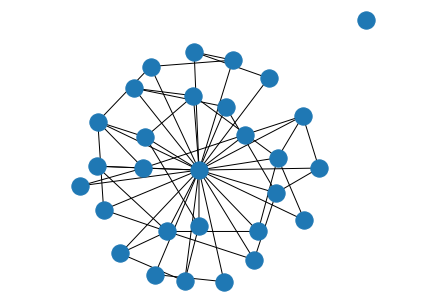

In [53]:
cls = 'wheel'
neg_result[cls] = neg_trainer[cls].evaluate_neg(0.3, show_neg_edges=False)

# Ladder Graph Interpretation

In [205]:
cls = 'ladder'
sampler[cls] = s = BinaryConcreteGraphSampler(n=40, temperature=0.5)
criterion[cls] = nn.Sequential(
    ClassScoreCriterion(class_idx=idx[cls]), # Maximize score
    NormPenalty(lambda: s.omega, order=1, weight=0), # L1 penalty on omega, encourage uncertainty
    NormPenalty(lambda: s.omega, order=2, weight=30), # L2 penalty on omega, avoid extreme probabilities
    BudgetPenalty(lambda: s.E, budget=20, beta=0.5, weight=500), # Budget penalty on theta, encourage sparsity
    CrossEntropyPenalty(lambda: s.theta, weight=0), # Element-wise entropy penalty on theta, encourage discreteness
    KLDivergencePenalty(lambda: tuple(s.E[s.pair_index]), weight=25), # Pair-wise cross entropy on E, encourage connectivity
)
optimizer[cls] = torch.optim.Adam(s.parameters(), lr=1)

# construct graph sampler trainer
trainer[cls] = Trainer(sampler=sampler[cls],
                       discriminator=discriminator,
                       criterion=criterion[cls],
                       optimizer=optimizer[cls])

## Train Positive Sampler

In [749]:
trainer['ladder'].train(iterations=3000)

  0%|          | 0/3000 [00:00<?, ?it/s]

iteration=0, loss=227.73, size=263.90240478515625, scores={'lollipop': 2.210176944732666, 'wheel': -1.0095796585083008, 'ladder': 0.44745099544525146, 'star': -4.574017524719238}
iteration=1, loss=151.66, size=163.69143676757812, scores={'lollipop': 2.066098928451538, 'wheel': -0.5464804172515869, 'ladder': 0.6115736961364746, 'star': -5.679479598999023}
iteration=2, loss=93.46, size=97.39396667480469, scores={'lollipop': 0.5124080777168274, 'wheel': 0.8108782768249512, 'ladder': -2.1337857246398926, 'star': -6.825645923614502}
iteration=3, loss=54.03, size=57.659942626953125, scores={'lollipop': 1.849787950515747, 'wheel': -1.5941364765167236, 'ladder': -3.2196359634399414, 'star': -8.962339401245117}
iteration=4, loss=31.92, size=34.368614196777344, scores={'lollipop': 1.7536133527755737, 'wheel': -0.5278568267822266, 'ladder': -5.064571380615234, 'star': -6.017938613891602}
iteration=5, loss=16.84, size=22.7410888671875, scores={'lollipop': 0.2602301836013794, 'wheel': -0.5854707956

In [206]:
cls = 'ladder'
sampler[cls].load(f'sampler_{cls}.ckpt')

## Draw Positive Sample

n=38 m=46


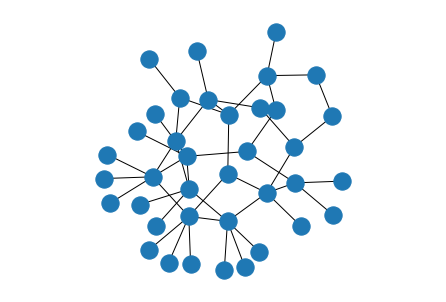

In [207]:
cls = 'ladder'
result[cls] = trainer[cls].evaluate(0.5)

In [ ]:
cls = 'ladder'
sampler[cls].save(f'sampler_{cls}.ckpt')

## Create Negative Sampler

In [225]:
cls = 'ladder'
neg_sampler[cls] = s = BinaryConcreteGraphSampler(n=40, edges=result[cls].edges)
neg_criterion[cls] = nn.Sequential(
    ClassScoreCriterion(class_idx=idx[cls], mode='minimize'), # Minimize score
    NormPenalty(lambda: s.omega, order=1, weight=0), # L1 penalty on omega, encourage uncertainty
    NormPenalty(lambda: s.omega, order=2, weight=5), # L2 penalty on omega, avoid extreme probabilities
    # TODO: change to E
    BudgetPenalty(lambda: s.theta, budget=10, beta=0.5, weight=30), # Budget penalty on theta, encourage sparsity
    CrossEntropyPenalty(lambda: s.theta, weight=0), # Element-wise entropy penalty on theta, encourage discreteness
    KLDivergencePenalty(lambda: tuple(s.E[s.pair_index]), weight=0), # Pair-wise cross entropy on E, encourage connectivity
)
neg_optimizer[cls] = torch.optim.Adam(s.parameters(), lr=0.1)

# construct graph sampler trainer
neg_trainer[cls] = Trainer(sampler=neg_sampler[cls],
                           discriminator=discriminator,
                           criterion=neg_criterion[cls],
                           optimizer=neg_optimizer[cls])

## Train Negative Sample

In [226]:
neg_trainer['ladder'].train(iterations=3000)

  0%|          | 0/3000 [00:00<?, ?it/s]

iteration=0, loss=9.58, size=24.104957580566406, scores={'lollipop': 1.604750156402588, 'wheel': -1.39388108253479, 'ladder': -1.1732592582702637, 'star': -3.0495283603668213}
iteration=1, loss=8.99, size=23.89389419555664, scores={'lollipop': 1.5163493156433105, 'wheel': -1.2691543102264404, 'ladder': -1.5611913204193115, 'star': -2.9426357746124268}
iteration=2, loss=10.67, size=23.59868621826172, scores={'lollipop': 0.918624997138977, 'wheel': -1.9918162822723389, 'ladder': 0.26402127742767334, 'star': -4.664726257324219}
iteration=3, loss=8.74, size=23.27533531188965, scores={'lollipop': 2.1032049655914307, 'wheel': -1.5390796661376953, 'ladder': -1.4623947143554688, 'star': -1.8062028884887695}
iteration=4, loss=9.41, size=22.92571258544922, scores={'lollipop': 1.6880871057510376, 'wheel': -1.5931832790374756, 'ladder': -0.5754232406616211, 'star': -3.2778799533843994}
iteration=5, loss=8.12, size=22.52347183227539, scores={'lollipop': 2.0130770206451416, 'wheel': -1.8400592803955

## Draw Negative Sample

n=11 m=8


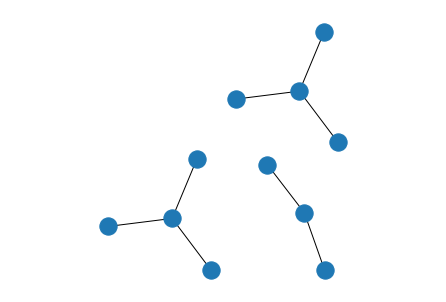

In [230]:
cls = 'ladder'
neg_trainer[cls].evaluate(0.4)

## Draw Contrastive Sample

n=38 m=38


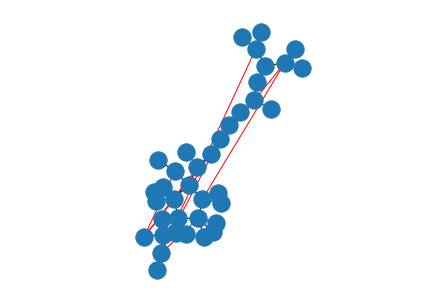

In [228]:
cls = 'ladder'
neg_result[cls] = neg_trainer[cls].evaluate_neg(0.4)

n=38 m=38


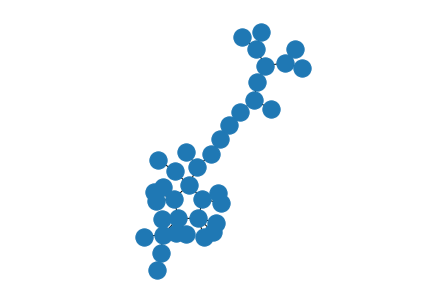

In [227]:
cls = 'ladder'
neg_result[cls] = neg_trainer[cls].evaluate_neg(0.4, show_neg_edges=False)